In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
file_data = r"E:\temp file\15009099\4FGL-DR4_v34_6classes_GMM_no_coord_features_weighted_prob_cat_v2.csv"
all_data_df = pd.read_csv(file_data)

In [3]:
feature_columns = ['sin(GLAT)', 'cos(GLON)', 'sin(GLON)', 'log10(Energy_Flux100)', 'log10(Unc_Energy_Flux100)', 'log10(Signif_Avg)', 'LP_index1000MeV', 'LP_beta', 'LP_SigCurv', 'log10(Variability_Index)']
label = 'CLASS1'
temp_df = all_data_df[feature_columns]

In [4]:
classes6 = {'spp+': ['nov', 'spp'], 'fsrq+': ['fsrq', 'nlsy1'], 'psr+': ['snr', 'hmb', 'pwn', 'psr', 'gc'],
                    'msp+': ['msp', 'lmc', 'glc', 'gal', 'sfr', 'bin'], 'bcu+': ['sey', 'bcu', 'sbg', 'agn', 'rdg'], 'bll+': ['bll', 'ssrq', 'css']}
classes4 = {'fsrq++': ['fsrq', 'nlsy1', 'css'], 'bll+': ['bll', 'sey', 'sbg', 'agn', 'ssrq', 'rdg'], 'psr+': ['snr', 'hmb', 'nov', 'pwn', 'psr', 'gc'], 'msp+': ['msp', 'lmb', 'glc', 'gal', 'sfr', 'bin']}
CLASS6 = {'spp+': 0, 'fsrq+': 1, 'psr+': 2, 'msp+': 3, 'bcu+': 4, 'bll+': 5}
CLASS4 = {'fsrq++': 0, 'bll+': 1, 'psr+': 2, 'msp+': 3}

In [5]:
def map_class1_to_class6(class1_value):
    for class6_group, class1_list in classes6.items():
        if class1_value in class1_list:
            return CLASS6[class6_group]
    return -1

def map_class1_to_class4(class1_value):
    for class4_group, class1_list in classes4.items():
        if class1_value in class1_list:
            return CLASS4[class4_group]
    return -1

In [6]:
all_data_df['CLASS6'] = all_data_df['CLASS1'].apply(map_class1_to_class6)
all_data_df['CLASS4'] = all_data_df['CLASS1'].apply(map_class1_to_class4)

In [7]:
class6_counts = all_data_df['CLASS6'].value_counts()
class4_counts = all_data_df['CLASS4'].value_counts()
print(class6_counts, class4_counts)

CLASS6
-1    2584
 4    1698
 5    1498
 1     827
 3     235
 2     219
 0     130
Name: count, dtype: int64 CLASS4
-1    4324
 1    1565
 0     833
 3     244
 2     225
Name: count, dtype: int64


In [8]:
all_data4 = all_data_df[all_data_df['CLASS4'] != -1][['name'] + feature_columns + ['CLASS4']]
print(all_data4.head())
X = all_data4[feature_columns]
y = all_data4['CLASS4']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

                 name  sin(GLAT)  cos(GLON)  sin(GLON)  log10(Energy_Flux100)  \
4   4FGL J0001.2-0747  -0.922572   0.016881   0.999857             -11.107484   
5   4FGL J0001.4-0010  -0.870281  -0.119998   0.992774             -11.881935   
6   4FGL J0001.5+2113  -0.645026  -0.303191   0.952930             -10.641685   
10  4FGL J0002.1-6728  -0.754291   0.643922  -0.765091             -11.612266   
15  4FGL J0002.8+6217  -0.000891  -0.458966   0.888454             -10.726508   

    log10(Unc_Energy_Flux100)  log10(Signif_Avg)  LP_index1000MeV   LP_beta  \
4                  -12.288400           1.389117         1.997502  0.037899   
5                  -12.508347           0.720296         2.139592 -0.010222   
6                  -12.195808           1.666760         2.865929  0.148902   
10                 -12.483412           1.222001         1.207217  0.160069   
15                 -11.886808           1.553799         2.108445  0.385295   

    LP_SigCurv  log10(Variability_Inde

In [9]:
print("数据集信息：")
print(f"样本总数：{len(X)}")
print(f"特征数：{X.shape[1]}")
print(f"类别数：{len(np.unique(y))}")
print(f"训练集大小：{len(X_train)}")
print(f"测试集大小：{len(X_test)}")

数据集信息：
样本总数：2867
特征数：10
类别数：4
训练集大小：2006
测试集大小：861


In [10]:
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',  # 多分类目标函数
    num_class=4,  # 类别数
    learning_rate=0.05,  # 学习率
    max_depth=3,  # 树的最大深度
    n_estimators=100,  # 树的数量
    random_state=42
)

# 训练模型
xgb_clf.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)],  # 验证集
            verbose=False)

# 预测
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)  # 预测概率

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
print(f"\n模型评估结果：")
print(f"测试集准确率：{accuracy:.4f}")
print("\n分类报告：")
print(classification_report(y_test, y_pred, target_names=['fsrq++', 'bll+', 'psr+', 'msp+']))


模型评估结果：
测试集准确率：0.8571

分类报告：
              precision    recall  f1-score   support

      fsrq++       0.81      0.78      0.80       267
        bll+       0.88      0.92      0.90       473
        psr+       0.87      0.87      0.87        52
        msp+       0.89      0.74      0.81        69

    accuracy                           0.86       861
   macro avg       0.86      0.83      0.84       861
weighted avg       0.86      0.86      0.86       861



[0.03748193 0.04331857 0.01636205 0.07233606 0.15628149 0.0339341
 0.29261464 0.18096413 0.06806131 0.09864577]


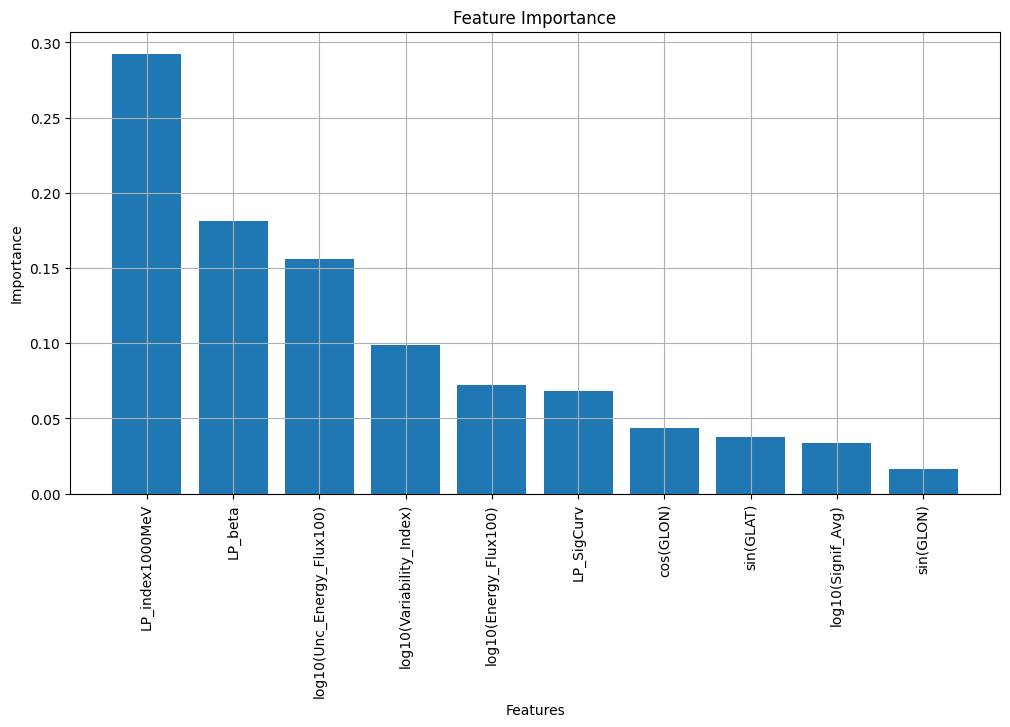

In [11]:
import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

feature_importances = xgb_clf.feature_importances_
print(feature_importances)
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), np.array(feature_columns)[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.grid(True)
plt.title('Feature Importance')
plt.show()

In [12]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 输出分类报告
print("分类报告:")
print(classification_report(y_test, y_pred))

# 输出准确率
print("准确率:", accuracy_score(y_test, y_pred))

# 如果需要，你可以查看特征重要性
print("特征重要性:")
print(rf_model.feature_importances_)

分类报告:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       267
           1       0.87      0.92      0.89       473
           2       0.86      0.81      0.83        52
           3       0.87      0.75      0.81        69

    accuracy                           0.85       861
   macro avg       0.85      0.81      0.83       861
weighted avg       0.85      0.85      0.85       861

准确率: 0.8548199767711963
特征重要性:
[0.04390957 0.03544393 0.03049451 0.06707198 0.11997649 0.05835826
 0.30334205 0.14494947 0.07910734 0.11734641]


In [13]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print("分类报告:")
print(classification_report(y_test, y_pred))
print("准确率:", accuracy_score(y_test, y_pred))

分类报告:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       267
           1       0.88      0.93      0.90       473
           2       0.83      0.87      0.85        52
           3       0.87      0.75      0.81        69

    accuracy                           0.87       861
   macro avg       0.86      0.83      0.84       861
weighted avg       0.87      0.87      0.87       861

准确率: 0.8664343786295006


聚类中心:
           sin(GLAT)  cos(GLON)  sin(GLON)  log10(Energy_Flux100)  \
Cluster 0   0.643391  -0.157257   0.075856             -11.500557   
Cluster 1   0.172233   0.167084  -0.087854             -11.602080   
Cluster 2  -0.584566   0.010301   0.082312             -11.432170   
Cluster 3   0.025229   0.098509   0.014730             -10.484384   

           log10(Unc_Energy_Flux100)  log10(Signif_Avg)  LP_index1000MeV  \
Cluster 0                 -12.396415           1.079921         2.095070   
Cluster 1                 -12.404586           1.044492         1.197833   
Cluster 2                 -12.325704           1.078873         2.121042   
Cluster 3                 -11.852543           1.706982         2.142280   

            LP_beta  LP_SigCurv  log10(Variability_Index)  
Cluster 0  0.078049    1.456386                  1.452324  
Cluster 1  0.353655    4.690725                  1.130894  
Cluster 2  0.086990    1.601280                  1.437694  
Cluster 3  0.155789    9.85

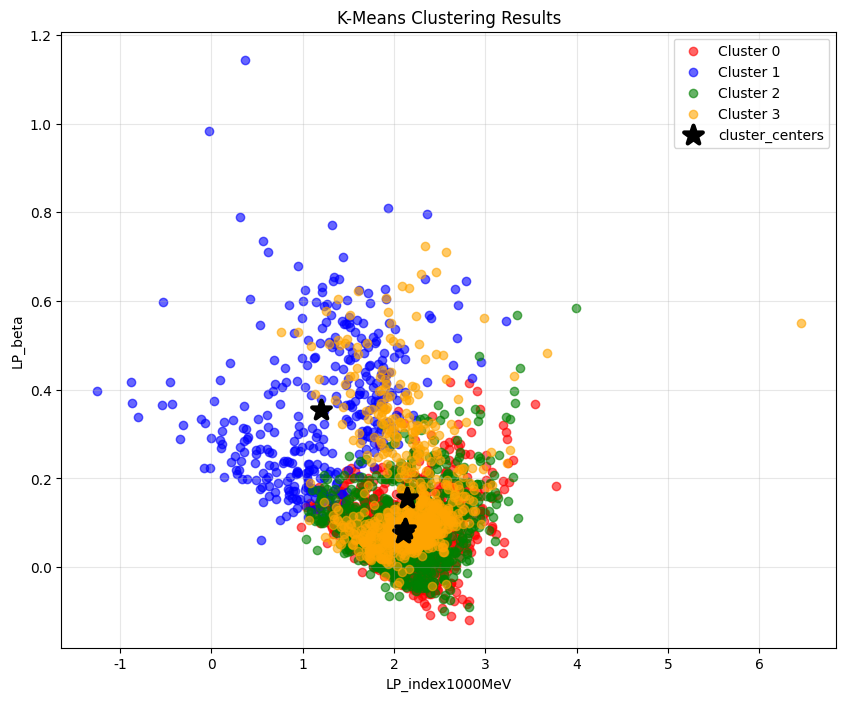

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42)  # 设定聚类数为4
kmeans.fit(X_scaled)

labels = kmeans.labels_

all_data4['Cluster'] = labels

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("聚类中心:")
cluster_center_df = pd.DataFrame(cluster_centers, columns=feature_columns)
cluster_center_df.index = [f'Cluster {i}' for i in range(4)]
print(cluster_center_df)

# 输出数据和聚类结果
# print(all_data4[['Cluster'] + feature_columns].head())

plt.figure(figsize=(10, 8))

# 为每个聚类定义颜色和标签
colors = ['red', 'blue', 'green', 'orange']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# 绘制每个聚类的数据点
for i in range(4):
    cluster_data = all_data4[all_data4['Cluster'] == i]
    plt.scatter(cluster_data['LP_index1000MeV'], cluster_data['LP_beta'], 
                c=colors[i], label=cluster_labels[i], alpha=0.6)

# 绘制聚类中心
plt.scatter(cluster_centers[:, 6], cluster_centers[:, 7], 
            c='black', marker='*', s=200, linewidths=3, label='cluster_centers')

plt.xlabel('LP_index1000MeV')
plt.ylabel('LP_beta')
plt.title('K-Means Clustering Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()